<a href="https://colab.research.google.com/github/dustoff06/FERP/blob/main/FERP_Copula.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal, gumbel_r, kurtosis

def estimate_scale_gumbel(data):
    """
    Estimate the scale parameter for the Gumbel distribution based on sample kurtosis.
    """
    k = kurtosis(data, axis=0)
    k_mean = np.mean(k)
    beta_est = np.sqrt(6) / np.pi * np.std(data, axis=0)
    return np.mean(beta_est)

def nearest_positive_definite(matrix):
    """
    Ensures the given matrix is positive definite by adjusting small eigenvalues.
    """
    eigval, eigvec = np.linalg.eigh(matrix)
    eigval[eigval < 1e-6] = 1e-6
    return eigvec @ np.diag(eigval) @ eigvec.T

def estimate_covariance(df, epsilon=1e-6):
    """
    Computes the empirical correlation matrix from ranking data.
    """
    standardized_rankings = (df - df.mean(axis=0)) / (df.std(axis=0, ddof=1) + epsilon)
    Sigma = np.corrcoef(standardized_rankings.T)
    Sigma += np.eye(Sigma.shape[0]) * epsilon
    if not np.all(np.linalg.eigvals(Sigma) > 0):
        Sigma = nearest_positive_definite(Sigma)
    return Sigma

def rank_to_uniform(rankings):
    """
    Convert rankings to uniform [0,1] variables using empirical CDF
    """
    n = len(rankings)
    return pd.Series(rankings).rank(method='average') / (n + 1)

def gumbel_copula_monte_carlo(rankings1, rankings2, rankings3, num_samples=10000):
    """
    Computes the Gumbel-based joint probability using Monte Carlo approximation.
    """
    df_rankings = pd.DataFrame({'rank1': rankings1, 'rank2': rankings2, 'rank3': rankings3})
    n_items = len(rankings1)

    if np.any(df_rankings.nunique() < n_items * 0.8):
        print("⚠️ Warning: Some rankings may contain too many ties!")

    beta_est = estimate_scale_gumbel(df_rankings.values)
    U1 = rank_to_uniform(rankings1)
    U2 = rank_to_uniform(rankings2)
    U3 = rank_to_uniform(rankings3)

    Sigma = estimate_covariance(df_rankings)
    normal_samples = multivariate_normal.rvs(mean=np.zeros(3), cov=Sigma, size=num_samples)
    gumbel_samples = gumbel_r.cdf(normal_samples, scale=beta_est)

    joint_prob = np.mean(
        (gumbel_samples[:, 0] <= U1.values[:, None]) &
        (gumbel_samples[:, 1] <= U2.values[:, None]) &
        (gumbel_samples[:, 2] <= U3.values[:, None]),
        axis=1
    )

    cond_prob_1 = gumbel_r.cdf(U1, scale=beta_est)
    cond_prob_2 = gumbel_r.cdf(U2, scale=beta_est)
    cond_prob_3 = gumbel_r.cdf(U3, scale=beta_est)

    conditional_marginals = {
        "P(U1 | U2, U3)": cond_prob_1.mean(),
        "P(U2 | U1, U3)": cond_prob_2.mean(),
        "P(U3 | U1, U2)": cond_prob_3.mean()
    }

    return joint_prob, conditional_marginals

np.random.seed(42)
n_items = 100
rankings1 = np.random.randint(1, n_items//2, n_items)
rankings2 = rankings1 + np.random.normal(0, 10, n_items)
rankings3 = np.random.permutation(n_items) + 1
joint_prob, conditional_marginals = gumbel_copula_monte_carlo(rankings1, rankings2, rankings3)

print(f"Joint Probability (Gumbel-Copula - Monte Carlo): {joint_prob.mean():.6f}")
print("Conditional Marginals:", conditional_marginals)


⚠️ Warning: Some rankings may contain too many ties!
Joint Probability (Gumbel-Copula - Monte Carlo): 0.290810
Conditional Marginals: {'P(U1 | U2, U3)': 0.3794614449845358, 'P(U2 | U1, U3)': 0.379461443277313, 'P(U3 | U1, U2)': 0.37946144327731296}


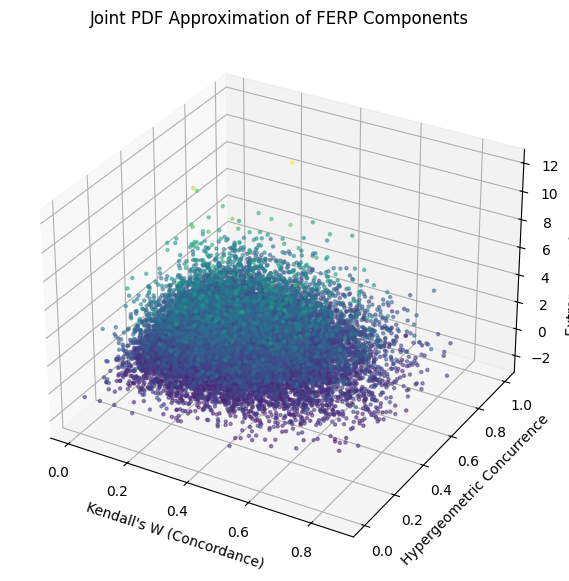

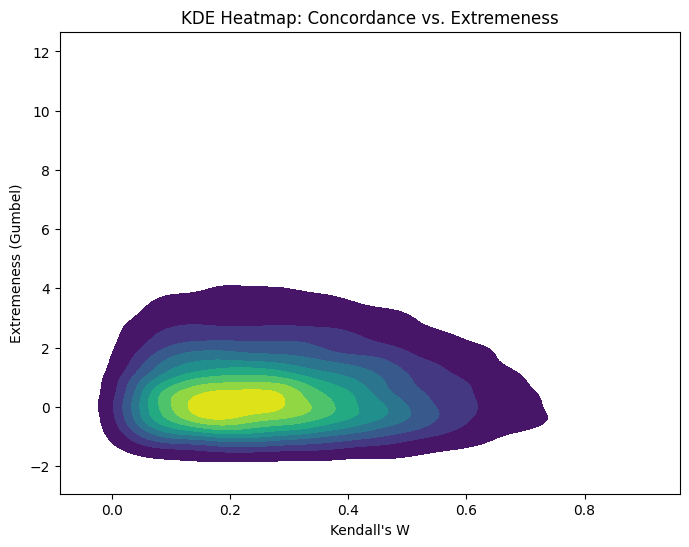

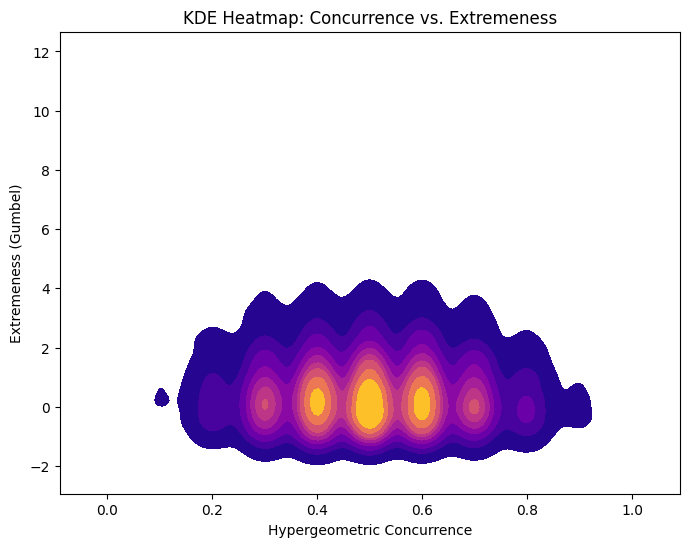

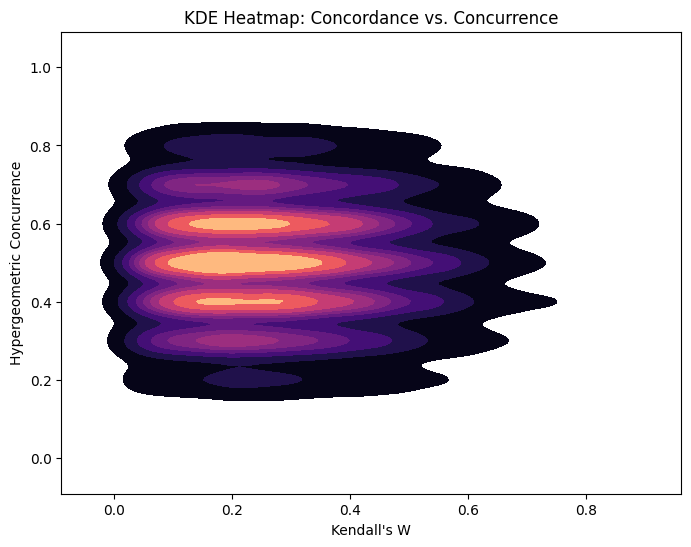

   Kendall_W  Hypergeometric_Concurrence  Extremeness_Gumbel
0   0.279825                         0.0            0.692136
1   0.148391                         0.4            4.853262
2   0.412955                         0.5            0.252974
3   0.108840                         0.5            0.336208
4   0.140587                         0.4            0.830776


In [ ]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D

# Generate Monte Carlo samples
N = 20000  # Number of samples

# Simulate Kendall's W (Concordance) as a beta distribution (approximation)
kendall_w = np.random.beta(a=2, b=5, size=N)  # Adjust shape parameters as needed

# Simulate Hypergeometric Concurrence as a binomial approximation (continuous)
hypergeom_concurrence = np.random.binomial(n=10, p=0.5, size=N) / 10  # Normalized

# Simulate Extremeness using a Gumbel distribution
extremeness_gumbel = np.random.gumbel(loc=0, scale=1, size=N)

# Create a DataFrame for visualization
df = pd.DataFrame({
    'Kendall_W': kendall_w,
    'Hypergeometric_Concurrence': hypergeom_concurrence,
    'Extremeness_Gumbel': extremeness_gumbel
})

# Generate 3D Density Plot (Scatter Approximation)
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot density representation
ax.scatter(df['Kendall_W'], df['Hypergeometric_Concurrence'], df['Extremeness_Gumbel'],
           c=df['Extremeness_Gumbel'], cmap='viridis', alpha=0.5, s=5)

ax.set_xlabel("Kendall's W (Concordance)")
ax.set_ylabel("Hypergeometric Concurrence")
ax.set_zlabel("Extremeness (Gumbel)")
ax.set_title("Joint PDF Approximation of FERP Components")

plt.show()

# Show KDE heatmap for Kendall's W vs. Extremeness (Gumbel)
plt.figure(figsize=(8, 6))
sns.kdeplot(x=df["Kendall_W"], y=df["Extremeness_Gumbel"], fill=True, cmap="viridis")
plt.xlabel("Kendall's W")
plt.ylabel("Extremeness (Gumbel)")
plt.title("KDE Heatmap: Concordance vs. Extremeness")
plt.show()

# Show KDE heatmap for Hypergeometric Concurrence vs. Extremeness (Gumbel)
plt.figure(figsize=(8, 6))
sns.kdeplot(x=df["Hypergeometric_Concurrence"], y=df["Extremeness_Gumbel"], fill=True, cmap="plasma")
plt.xlabel("Hypergeometric Concurrence")
plt.ylabel("Extremeness (Gumbel)")
plt.title("KDE Heatmap: Concurrence vs. Extremeness")
plt.show()

# Show KDE heatmap for Kendall's W vs. Hypergeometric Concurrence
plt.figure(figsize=(8, 6))
sns.kdeplot(x=df["Kendall_W"], y=df["Hypergeometric_Concurrence"], fill=True, cmap="magma")
plt.xlabel("Kendall's W")
plt.ylabel("Hypergeometric Concurrence")
plt.title("KDE Heatmap: Concordance vs. Concurrence")
plt.show()

# Display the generated data
print(df.head())
